**MOUNTING GDRIVE**

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


**IMPORTING THE LIBRARIES**

In [2]:
import os, cv2, json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications import EfficientNetB6
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam
from PIL import Image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Input, BatchNormalization, GlobalAveragePooling2D

**LOADING THE DATASET**

In [3]:
train= pd.read_csv("/content/drive/MyDrive/new proj/train.csv")

**SPLITTING THE DATASET**

In [4]:
from sklearn.model_selection import train_test_split
df_train, df_validate, y_train, y_test = train_test_split(train, train.label, train_size=0.8, random_state=42, stratify=train.label)
df_train = df_train.reset_index(drop=True)
df_validate = df_validate.reset_index(drop=True)

**VISUALIZING THE DATASET**

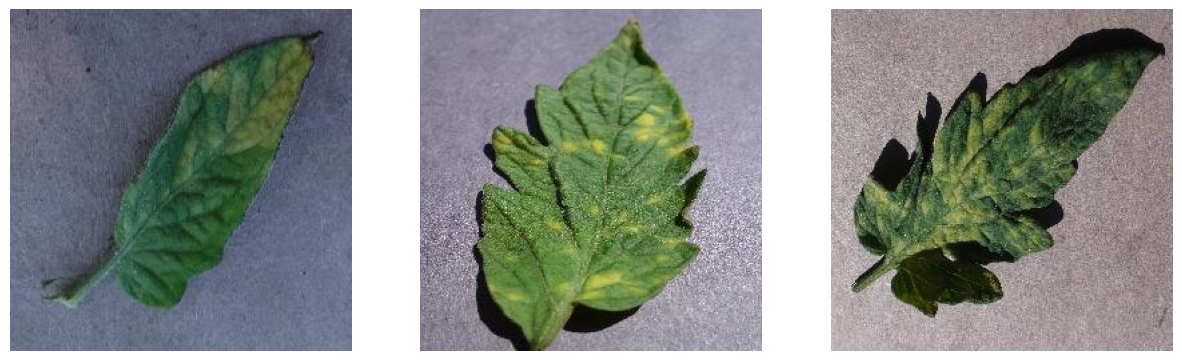

In [5]:
sample = df_train[df_train.label == 3].sample(3)
plt.figure(figsize=(15, 5))
for ind, (img, label) in enumerate(zip(sample.img, sample.label)):
    plt.subplot(1, 3, ind + 1)
    img = cv2.imread(os.path.join("/content/drive/MyDrive/new proj/Tomato_images", img))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.axis("off")
plt.show()

**PARAMETERS**

In [6]:
# Main parameters
BATCH_SIZE = 16
STEPS_PER_EPOCH = len(train)*0.8 / BATCH_SIZE
VALIDATION_STEPS = len(train)*0.2 / BATCH_SIZE
EPOCHS =60 #
IMG_WIDTH= 256
IMG_HEIGHT= 256
train_dir = "/content/drive/MyDrive/new proj/Tomato_images"
df_train.label = df_train.label.astype('str')
df_validate.label = df_validate.label.astype('str')

**DATA GENERATOR FOR AUGMENTATION AND ROBUSTNESS**

In [7]:
train_datagen = ImageDataGenerator(rescale=1./255, shear_range = 0.2, zoom_range = 0.2, rotation_range = 180, vertical_flip = True, horizontal_flip = True)
# our train_datagen generator will use the following transformations on the images
validation_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_dataframe(df_train, train_dir, target_size=(IMG_WIDTH, IMG_HEIGHT), batch_size=BATCH_SIZE, x_col='img', y_col='label', class_mode = 'categorical')
validation_generator = validation_datagen.flow_from_dataframe(df_validate, train_dir, target_size=(IMG_WIDTH, IMG_HEIGHT), x_col='img', y_col='label', class_mode='categorical', batch_size=BATCH_SIZE)

Found 4800 validated image filenames belonging to 10 classes.
Found 1200 validated image filenames belonging to 10 classes.


**BUILDING MODEL**

87910968/87910968 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 2048)              21802784  
                                                                 
 dense (Dense)               (None, 10)                20490     
                                                                 
Total params: 21823274 (83.25 MB)
Trainable params: 21788842 (83.12 MB)
Non-trainable params: 34432 (134.50 KB)
_________________________________________________________________
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 2048)              21802784  
                                                                 
 dense (Dense)               (None, 10)                20

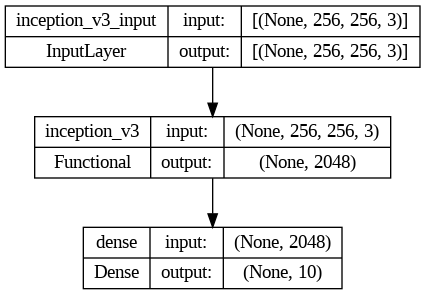

In [8]:
def create_model():
    efficientnet_layers = InceptionV3(weights='imagenet', include_top=False, input_shape = (IMG_WIDTH, IMG_HEIGHT, 3), pooling='avg')
    model = Sequential()
    model.add(efficientnet_layers)
    model.add(Dense(10, activation="softmax"))
    model.compile(optimizer = Adam(learning_rate = 0.001), loss = "categorical_crossentropy", metrics = ["acc"])
    return model

model = create_model()
model.summary()

from keras.utils import plot_model
model.summary()
# plot model architecture
plot_model(model, show_shapes=True, to_file='naive_inception_module.png')

**TRAINING**

In [ ]:
model_save = ModelCheckpoint('./InceptionV3_256.h5', save_best_only = True, save_weights_only = False, monitor = 'val_loss', mode = 'min', verbose = 1)
early_stop = EarlyStopping(monitor = 'val_loss', min_delta = 0.001, patience = 10, mode = 'min', verbose = 1, restore_best_weights = True)
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.3, patience = 2, min_delta = 0.001, mode = 'min', verbose = 1)
history = model.fit(train_generator, steps_per_epoch = STEPS_PER_EPOCH, epochs = EPOCHS, validation_data = validation_generator, validation_steps = VALIDATION_STEPS, callbacks = [model_save, early_stop,reduce_lr])

Epoch 1/60
300/300 [==============================] - ETA: 0s - loss: 0.8792 - acc: 0.7113 
Epoch 1: val_loss improved from inf to 7.19213, saving model to ./InceptionV3_256.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


300/300 [==============================] - 3763s 12s/step - loss: 0.8792 - acc: 0.7113 - val_loss: 7.1921 - val_acc: 0.2167 - lr: 0.0010
Epoch 2/60
300/300 [==============================] - ETA: 0s - loss: 0.4916 - acc: 0.8390 
Epoch 2: val_loss improved from 7.19213 to 3.36167, saving model to ./InceptionV3_256.h5
300/300 [==============================] - 3444s 11s/step - loss: 0.4916 - acc: 0.8390 - val_loss: 3.3617 - val_acc: 0.4683 - lr: 0.0010
Epoch 3/60
160/300 [===============>..............] - ETA: 26:00 - loss: 0.3801 - acc: 0.8750